In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from ast import literal_eval
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import re


number of episodes finished 1846
number of time-steps finished 923000
CapturedByDefense    1026
OutOfBounds           426
OutOfTime             392
Goal                    2
Name: why, dtype: int64


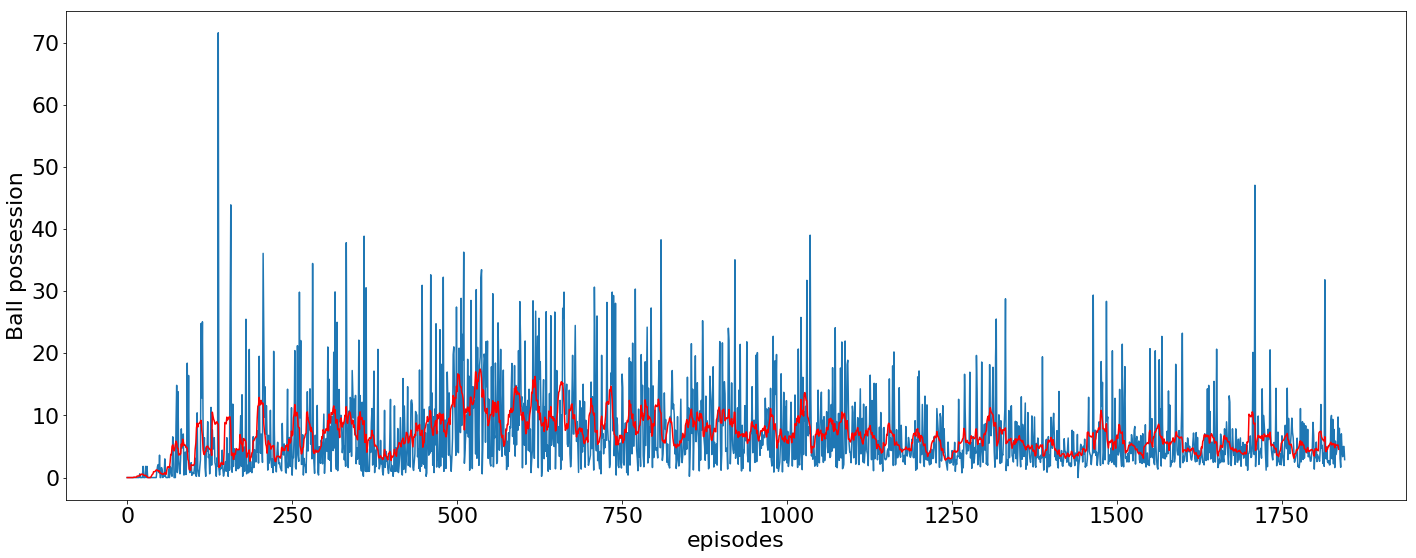

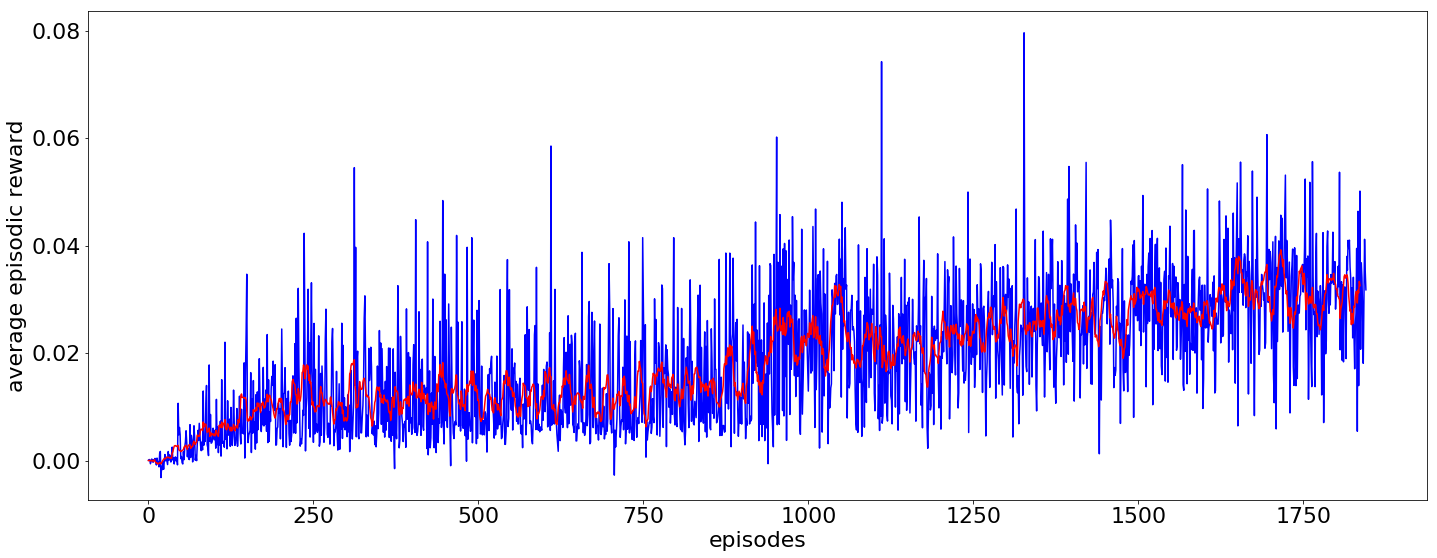

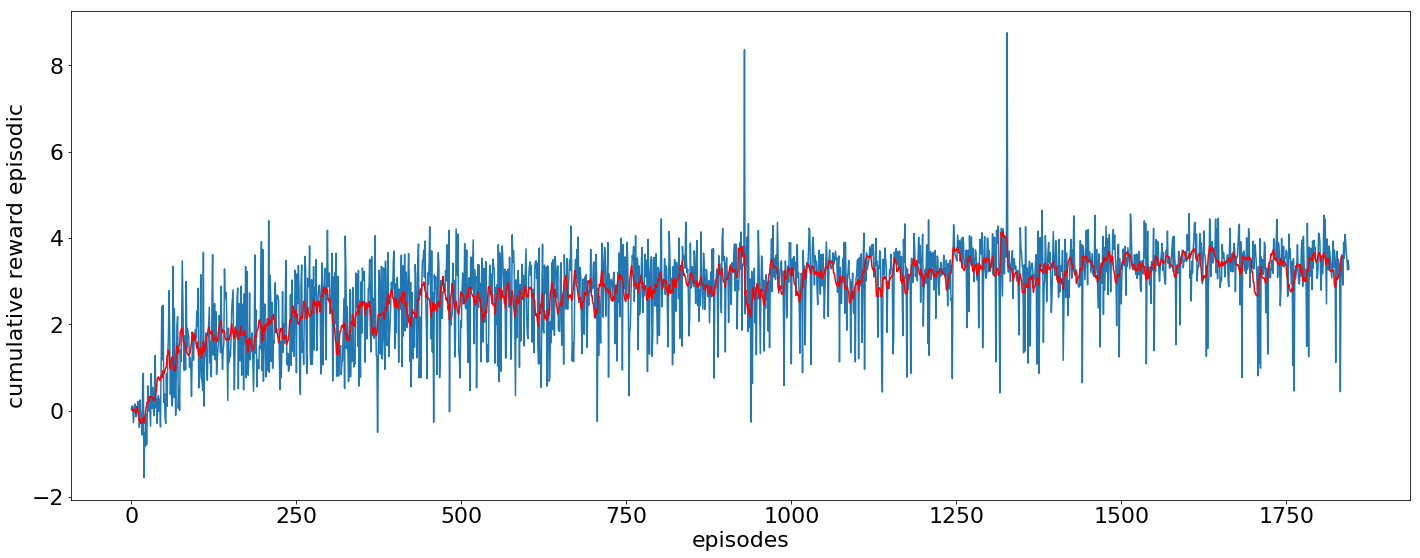

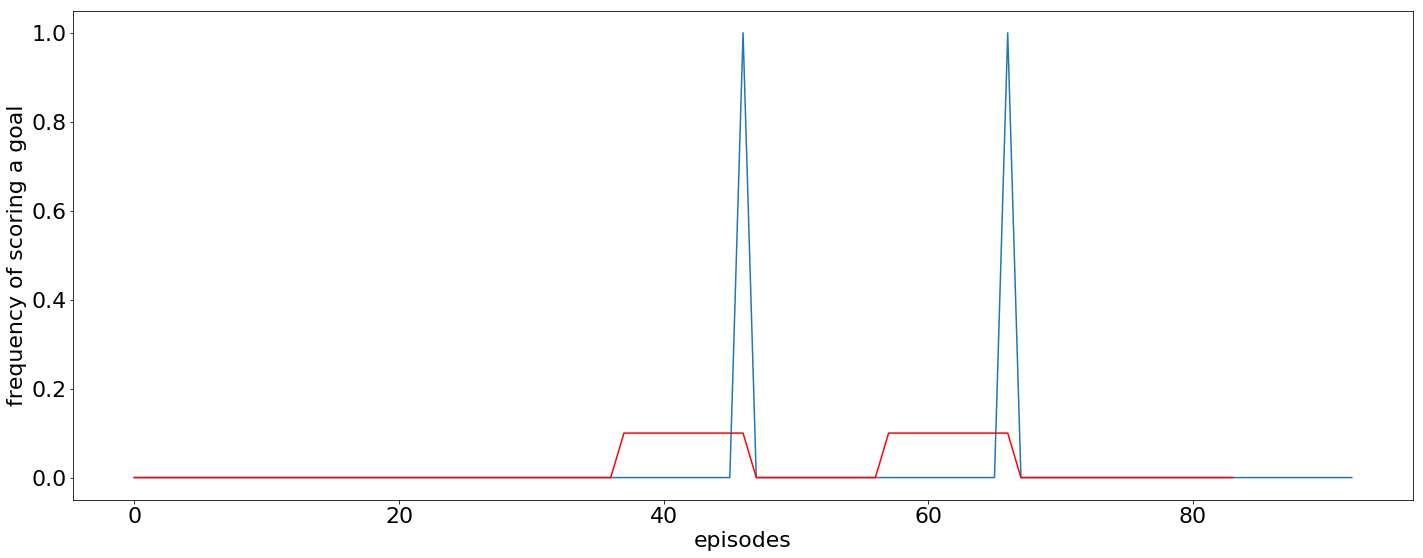

In [83]:
data = pd.read_csv('history.csv')

print('number of episodes finished %d'%len(data))

print('number of time-steps finished %d'%(len(data)*500))

    
print(data.why.value_counts())

goal_frequency_window = 20

######################################---ball possession  and smoothed curve---#########################################################

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(data.kickable_percentages  )
plt.plot( np.convolve(data.kickable_percentages, np.ones((10,))/10, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('Ball possession')
plt.show()



######################################--- average episodic reward and smoothed curve-----#########################################################
reward = []
for i in range(len(data)):
    reward.append(literal_eval(data.average_reward[i]))
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(reward, '-b')
#plt.plot(data.manual_average_reward, '-g')
plt.plot( np.convolve(np.ravel(reward) , np.ones((10,))/10, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('average episodic reward')
plt.show()

######################################--- cumulative episodic reward and smoothed curve-----#########################################################

reward = []
for i in range(len(data)):
    reward.append(literal_eval(data.cumulative_reward[i]))
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))

plt.plot(reward)
#plt.plot(data.manual_sum_reward, '-g')
plt.plot( np.convolve(np.ravel(reward) , np.ones((10,))/10, mode='valid'), '-r' )

plt.xlabel('episodes')
plt.ylabel('cumulative reward episodic')
plt.show()

#####################################################


goal_freq = []
for i in range(0, len(data), goal_frequency_window):
    temp = data.loc[i:i+goal_frequency_window].why.value_counts()
    
    try: 
        goal_freq.append(temp.Goal)
    except AttributeError:
        goal_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_freq)
plt.plot( np.convolve(np.ravel(goal_freq) , np.ones((10,))/10, mode='valid'), '-r' )
plt.xlabel('episodes')
plt.ylabel('frequency of scoring a goal')
plt.show()

In [19]:
fname = 'log/base_left-11.log'
with open(fname) as f:
    content = f.readlines()

content = [x.strip() for x in content]
#content
len(content)

GameStates = 0
StateFeatures = 0
actions_counter = 0

def act_analyzer(content):
    GameStates = 0
    StateFeatures = 0
    actions_counter = 0

    actions = pd.DataFrame(columns=['ts', 'act_raw', 'act', 'power', 'direction'])
    for i in range(len(content)):
        if content[i].split(' ')[3] == 'GameStatus':
            GameStates+=1
        elif content[i].split(' ')[3] == 'StateFeatures':
            StateFeatures +=1
        else:#if content[i].split(' ')[3] =='/home.sda4/home/ssajjadi/Desktop/ML/work/HFO-master/build/librcsc-prefix/src/librcsc/rcsc/player/player_agent.cpp:':
            actions_counter+=1
            s = content[i].split(' ')[4]  
            if "Dash"  in s: 
                result = re.search('Dash((.*),*)', s)
                power = float(result.group(1).split(',')[0][1:])
                direction = float(result.group(1).split(',')[1][:-1])
                act = 'dash'
            elif "Turn"  in s: 
                result = re.search('Turn((.*))', s)
                direction =float(result.group(1)[1:-1])
                power = float(-1440)
                act = 'turn'
            elif "Kick"  in s: 
                result = re.search('Kick((.*),*)', s)
                power = float(result.group(1).split(',')[0][1:])
                direction = float(result.group(1).split(',')[1][:-1])
                act = 'kick'
                
            actions = actions.append({'ts': content[i].split(' ')[0] ,
                                     'act_raw': s ,
                                     'act': act, 
                                     'power': power, 
                                     'direction': direction}, ignore_index= True )
            
            
    return actions


print('number of observed Game states as --GameStatus--: ', GameStates)
print('number of observed Game states as --:StateFeatures--: ', StateFeatures)
print('number of valid actions taken in the env: ' ,actions_counter)


number of observed Game states as --GameStatus--:  0
number of observed Game states as --:StateFeatures--:  0
number of valid actions taken in the env:  0


In [ ]:
chunksize = len(content)//(mp.cpu_count() - 1)
list_content = []
for i in range(0,len(content)-chunksize, chunksize):
    list_content.append(content[i:i+chunksize])
    
pool = mp.Pool(processes = (mp.cpu_count() - 1))
results = pool.map( act_analyzer,  list_content)
pool.close()
pool.join()

results_df = pd.concat(results)

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( range(len(results_df[results_df.act == 'dash'])), results_df[results_df.act == 'dash'].power )
plt.xlabel('timesteps')
plt.ylabel('dash power')
plt.show()


plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( range(len(results_df[results_df.act == 'dash'])) , results_df[results_df.act == 'dash'].direction )
plt.xlabel('timesteps')
plt.ylabel('dash direction')
plt.show()



plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( range(len(results_df[results_df.act == 'turn'])) , results_df[results_df.act == 'turn'].direction )
plt.xlabel('timesteps')
plt.ylabel('turn direction')
plt.show()


plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( range(len( results_df[results_df.act == 'kick'])) , results_df[results_df.act == 'kick'].power )
plt.xlabel('timesteps')
plt.ylabel('kick power')
plt.show()


plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot( range(len( results_df[results_df.act == 'kick'])) , results_df[results_df.act == 'kick'].direction )
plt.xlabel('timesteps')
plt.ylabel('kick direction')
plt.show()